In [1]:
# from google.colab import drive
# drive.mount ("/content/drive")

In [2]:
import os # accessing directory structure
import random
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg

In [3]:
# Replace with the path to your directory
directory_path = "Work/Pothole_Image_Data"

In [4]:
# Create empty lists to store file paths and labels
listImageFilePaths = []
listLabels = []

for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        # Check if the file is an image file
        if filename.lower().endswith(('.bmp', '.gif', '.jpeg', '.jpg', '.png')):
            # Add the file path to the list
            listImageFilePaths.append(os.path.join(dirname, filename))
            # Add the label to the list based on whether the filename contains 'pothole'
            listLabels.append('0' if 'plain' in filename.lower() else '1')

# Print the total number of images
print('Total images: ', len(listImageFilePaths), "Label length: ", len(listLabels))

Total images:  1180 Label length:  1180


In [5]:
def displayImage(imagePath):
    image = mpimg.imread(imagePath)
    plt.imshow(image)
    print('Image path', imagePath)
    #print('Image size -', image.shape)
    plt.show()

In [6]:
def displayRandomImages(listImageFilePaths, nImageToDisplay):
    listImageIndex = random.sample(range(0, len(listImageFilePaths)), nImageToDisplay)
    
    for imageIndex in listImageIndex:
        displayImage(listImageFilePaths[imageIndex])
        print("Label: ", listLabels[imageIndex])

In [7]:
type(listImageFilePaths[0])

str

Image path Work/Pothole_Image_Data/303.jpg


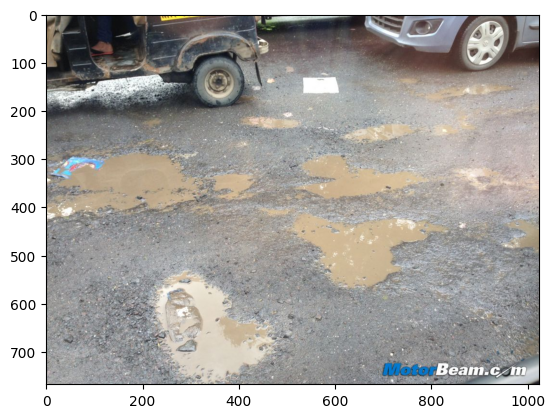

Label:  1
Image path Work/Pothole_Image_Data/341.jpg


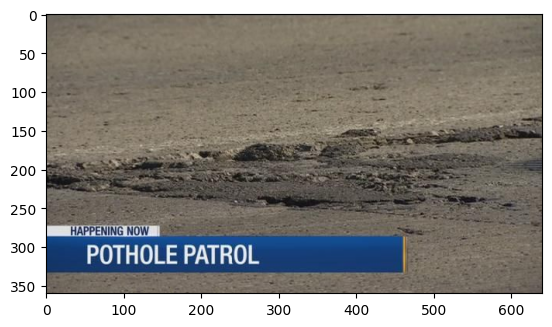

Label:  1
Image path Work/Pothole_Image_Data/415.jpg


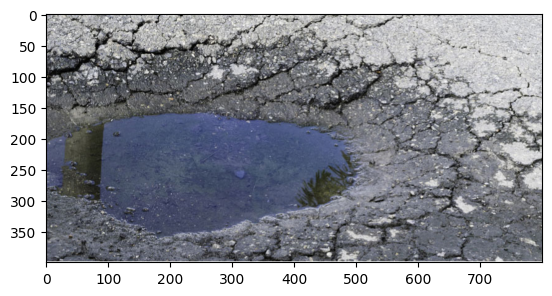

Label:  1
Image path Work/Pothole_Image_Data/322.jpg


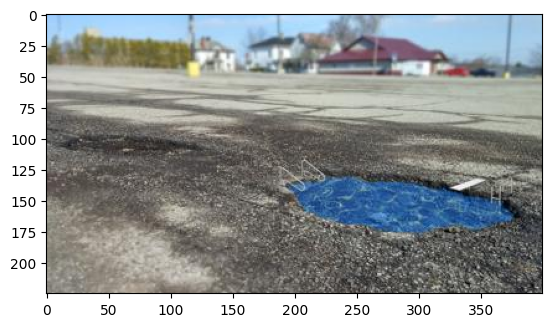

Label:  1
Image path Work/Pothole_Image_Data/200.jpg


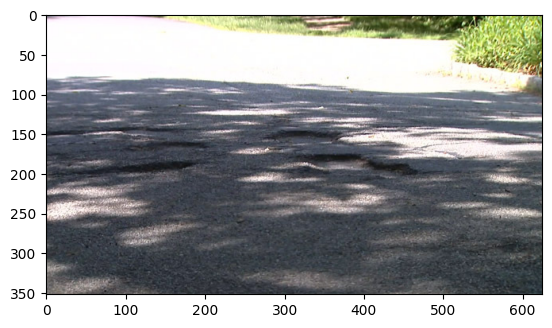

Label:  1


In [8]:
displayRandomImages(listImageFilePaths, nImageToDisplay = 5)

# VGG

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# set the input size of the images
input_size = (224, 224)
batch_size = 32
num_classes = 2

In [13]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
# load the pre-trained model (VGG16 in this case) without the fully-connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_size[0], input_size[1], 3))

58889256/58889256 [==============================] - 8s 0us/step


In [16]:
# add your own fully-connected layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [17]:
# define the new model
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# freeze the weights of the base model so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# compile the model with a binary cross-entropy loss and an SGD optimizer with a low learning rate
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=['accuracy'])

In [20]:
# set up the data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
from sklearn.model_selection import train_test_split

train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(listImageFilePaths, listLabels, test_size=0.2, random_state=42)

In [22]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filepath': train_image_paths, 'label': train_labels}),
    x_col='filepath',
    y_col='label',
    target_size=input_size,
    batch_size=batch_size,
    class_mode='binary')


valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filepath': valid_image_paths, 'label': valid_labels}),
    x_col='filepath',
    y_col='label',
    target_size=input_size,
    batch_size=batch_size,
    class_mode='binary')

Found 944 validated image filenames belonging to 2 classes.
Found 236 validated image filenames belonging to 2 classes.


In [23]:
import warnings
warnings.filterwarnings("ignore", message="Palette images with Transparency expressed in bytes should be converted to RGBA images")

In [24]:
# train the model for a few epochs
model.fit_generator(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=valid_generator, validation_steps=len(valid_generator))

/var/folders/px/544lvycn58z65rdg800zkv9h0000gn/T/ipykernel_1634/2933313895.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=valid_generator, validation_steps=len(valid_generator))


Epoch 1/10
30/30 [==============================] - 128s 4s/step - loss: 0.6629 - accuracy: 0.6557 - val_loss: 0.4195 - val_accuracy: 0.7500
Epoch 2/10
30/30 [==============================] - 146s 5s/step - loss: 0.4306 - accuracy: 0.8083 - val_loss: 0.3228 - val_accuracy: 0.9237
Epoch 3/10
30/30 [==============================] - 147s 5s/step - loss: 0.3281 - accuracy: 0.8888 - val_loss: 0.2706 - val_accuracy: 0.9025
Epoch 4/10
30/30 [==============================] - 152s 5s/step - loss: 0.3024 - accuracy: 0.9015 - val_loss: 0.2361 - val_accuracy: 0.9195
Epoch 5/10
30/30 [==============================] - 150s 5s/step - loss: 0.2563 - accuracy: 0.9206 - val_loss: 0.2174 - val_accuracy: 0.9237
Epoch 6/10
30/30 [==============================] - 324s 11s/step - loss: 0.2302 - accuracy: 0.9258 - val_loss: 0.2011 - val_accuracy: 0.9322
Epoch 7/10
30/30 [==============================] - 144s 5s/step - loss: 0.2196 - accuracy: 0.9354 - val_loss: 0.1949 - val_accuracy: 0.9280
Epoch 8/10
3

In [25]:
vgg_accuracy = model.evaluate(valid_generator, steps=len(valid_generator))[1]
print("VGG Net Accuracy:", vgg_accuracy)

8/8 [==============================] - 31s 4s/step - loss: 0.1763 - accuracy: 0.9322
VGG Net Accuracy: 0.9322034120559692


# Res Net

In [31]:
from tensorflow.keras.applications import ResNet50

In [33]:
ResNet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(input_size[0], input_size[1], 3))

94765736/94765736 [==============================] - 91s 1us/step


In [36]:
x = ResNet_base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
ResNet_model = Model(inputs=ResNet_base_model.input, outputs=predictions)

for layer in ResNet_base_model.layers:
    layer.trainable = False

ResNet_model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=['accuracy'])

In [37]:
history = ResNet_model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=valid_generator, validation_steps=len(valid_generator))

Epoch 1/10
30/30 [==============================] - 41s 1s/step - loss: 0.7670 - accuracy: 0.6017 - val_loss: 0.6831 - val_accuracy: 0.5805
Epoch 2/10
30/30 [==============================] - 42s 1s/step - loss: 0.6553 - accuracy: 0.6483 - val_loss: 0.5972 - val_accuracy: 0.7076
Epoch 3/10
30/30 [==============================] - 45s 1s/step - loss: 0.6370 - accuracy: 0.6769 - val_loss: 0.6053 - val_accuracy: 0.7076
Epoch 4/10
30/30 [==============================] - 919s 32s/step - loss: 0.6392 - accuracy: 0.6780 - val_loss: 0.6032 - val_accuracy: 0.7076
Epoch 5/10
30/30 [==============================] - 40s 1s/step - loss: 0.6334 - accuracy: 0.6769 - val_loss: 0.6189 - val_accuracy: 0.7076
Epoch 6/10
30/30 [==============================] - 42s 1s/step - loss: 0.6345 - accuracy: 0.6769 - val_loss: 0.6015 - val_accuracy: 0.7076
Epoch 7/10
30/30 [==============================] - 43s 1s/step - loss: 0.6291 - accuracy: 0.6780 - val_loss: 0.5988 - val_accuracy: 0.7076
Epoch 8/10
30/30 [

In [38]:
resnet_accuracy = ResNet_model.evaluate(valid_generator, steps=len(valid_generator))[1]
print("ResNet Accuracy:", resnet_accuracy)

8/8 [==============================] - 9s 1s/step - loss: 0.5977 - accuracy: 0.7076
ResNet Accuracy: 0.7076271176338196


In [ ]:
# ResNet_model.save('./ResNet_Model.h5')

# Inception Net

In [34]:
from tensorflow.keras.applications import InceptionV3

In [35]:
Inception_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(input_size[0], input_size[1], 3))

87910968/87910968 [==============================] - 88s 1us/step


In [40]:
x = Inception_base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

Inception_model = Model(inputs=Inception_base_model.input, outputs=predictions)

for layer in Inception_base_model.layers:
    layer.trainable = False

Inception_model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=['accuracy'])

In [41]:
history = Inception_model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=valid_generator, validation_steps=len(valid_generator))

Epoch 1/10
30/30 [==============================] - 30s 910ms/step - loss: 0.4031 - accuracy: 0.8294 - val_loss: 0.1553 - val_accuracy: 0.9619
Epoch 2/10
30/30 [==============================] - 29s 967ms/step - loss: 0.1524 - accuracy: 0.9449 - val_loss: 0.1135 - val_accuracy: 0.9788
Epoch 3/10
30/30 [==============================] - 31s 1s/step - loss: 0.1315 - accuracy: 0.9523 - val_loss: 0.1030 - val_accuracy: 0.9873
Epoch 4/10
30/30 [==============================] - 34s 1s/step - loss: 0.1245 - accuracy: 0.9576 - val_loss: 0.0967 - val_accuracy: 0.9873
Epoch 5/10
30/30 [==============================] - 34s 1s/step - loss: 0.1189 - accuracy: 0.9566 - val_loss: 0.0867 - val_accuracy: 0.9873
Epoch 6/10
30/30 [==============================] - 33s 1s/step - loss: 0.1069 - accuracy: 0.9587 - val_loss: 0.0820 - val_accuracy: 0.9873
Epoch 7/10
30/30 [==============================] - 36s 1s/step - loss: 0.0948 - accuracy: 0.9693 - val_loss: 0.0973 - val_accuracy: 0.9831
Epoch 8/10
30/

In [42]:
inception_accuracy = Inception_model.evaluate(valid_generator, steps=len(valid_generator))[1]
print("Inception Accuracy:", inception_accuracy)

8/8 [==============================] - 6s 647ms/step - loss: 0.0840 - accuracy: 0.9873
Inception Accuracy: 0.9872881174087524


In [ ]:
# Inception_model.save('./Inception_Model.h5')

# Best performance by Inception Net

In [26]:
# Inception_model.save('/content/drive/MyDrive/Colab_Notebooks/Model')

In [45]:
import cv2
folder_path = 'Test'
image_files = os.listdir(folder_path)

s=0
for image_file in image_files:
    # Read the image
    image_path = os.path.join(folder_path, image_file)
    image = cv2.imread(image_path)
    # Preprocess the image
    image = cv2.resize(image, (224, 224))  # Resize image to match input size of the model
    image = image / 255.0  # Normalize pixel values
    
    # Make prediction
    prediction = Inception_model.predict(np.expand_dims(image, axis=0))
    valid_prediction = (prediction > 0.5).astype(int)
    pred = "YES" if valid_prediction==1 else "NO"

    if("Plain" in image_file):
        if(valid_prediction==0):
            s=s+1
    else:
        if(valid_prediction==1):
            s=s+1
    # Display the result
    print(f'Image: {image_file}, Prediction: {pred}')

acc = (s*100)/len(image_files)
print(f'\nTest Accuracy: {acc}')

1/1 [==============================] - 0s 86ms/step
Image: 11.jpg, Prediction: YES
1/1 [==============================] - 0s 50ms/step
Image: Plain1354.jpg, Prediction: NO
1/1 [==============================] - 0s 46ms/step
Image: 27.jpg, Prediction: YES
1/1 [==============================] - 0s 46ms/step
Image: 133.jpg, Prediction: YES
1/1 [==============================] - 0s 45ms/step
Image: Plain1361.jpg, Prediction: NO
1/1 [==============================] - 0s 49ms/step
Image: 68.jpg, Prediction: YES

Test Accuracy: 100.0
